<a href="https://colab.research.google.com/github/jesperiksson/SoccermaticsForPython/blob/master/simulate_seasons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Oct 24 15:00:30 2020

@author: jesper
"""

In [12]:
from google.colab import drive
drive.mount('/content/drive/')
path  = '/content/drive/My Drive/Fotbollsmatte/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [13]:
url1718 = 'https://raw.githubusercontent.com/jesperiksson/SoccermaticsForPython/master/PL1718.csv'
url1819 = 'https://raw.githubusercontent.com/jesperiksson/SoccermaticsForPython/master/PL1819.csv'
url1920 = 'https://raw.githubusercontent.com/jesperiksson/SoccermaticsForPython/master/PL1920.csv'

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sn
import copy
import pickle 

# Table class 
A table object contains the ta table at the end of a season

In [15]:
class Table():
    # Makes a table at the end of a season
    def __init__(self):
        self.table = pd.DataFrame( # Initiate an empty table
            columns = ['Team','Points','Win','Draw','Lose','Goals for','Goals against','Goal difference']
            )
        self.games = pd.DataFrame(
            columns = ['Home','Away','HG','AG']
            )
        
    def add_numbers(self,team_list): # Is called from the simulate_season method of the Stats class
        for i in range(len(team_list)):
            t = team_list[i]
            self.table = self.table.append(
                pd.DataFrame(
                    [[t.name,(t.wins*3+t.draws*1),t.wins,t.draws,t.losses,
                      t.goals_for,t.goals_against,(t.goals_for-t.goals_against)]],
                    columns= ['Team','Points','Win','Draw','Lose','Goals for','Goals against','Goal difference']
                    )
                )
        self.table = self.table.sort_values(by=['Points','Goal difference','Goals for'],ascending=[False,False,False])
        self.table.index = range(1,len(self.table)+1)

    def add_dict(self,team_dict):
        self.team_dict = team_dict
    
    def show_table(self):
        return self.table

# Team class


In [16]:
class Team():
    # Team objects which populate the Table
    def __init__(self,name):
        self.name = name
        self.wins = 0
        self.draws = 0
        self.losses = 0
        self.goals_for = 0
        self.goals_against = 0
        
    def add_result(self,scored,conceded):
        if scored > conceded: # win
            self.wins += 1
        elif scored == conceded: # draw
            self.draws += 1
        else: # loss
            self.losses +=1 
        self.goals_for += scored
        self.goals_against += conceded

    def remove_result(self,scored,conceded): # For resimulating the entire season
        if scored > conceded: # win
            self.wins -= 1
        elif scored == conceded: # draw
            self.draws -= 1
        else: # loss
            self.losses -=1 
        self.goals_for -= scored
        self.goals_against -= conceded


# Stats class

In [17]:
class Stats(): # raw data, teams, colors, parameters, etc. 
    def __init__(self,df):
        self.df = df
        self.team_colors = {'Arsenal':'#ef0107', 'Aston Villa':'#95bfe5', 'Bournemouth':'#da291c', 'Brighton':'#0057b8',
               'Burnley':'#6c1d45', 'Chelsea':'#034694', 'Crystal Palace':'#1b458f', 'Everton':'#003399',
               'Leicester':'#003090', 'Liverpool':'#c8102e', 'Man City':'#6cabdd', 'Man United':'#da291c',
               'Newcastle':'#241f20', 'Norwich':'#fff200', 'Sheffield United':'#ee2737', 
               'Southampton':'#d71920', 'Tottenham':'#132257', 'Watford':'#fbee23', 'West Ham':'#7a263a',
               'Wolves':'#fdb913'}
        #https://towardsdatascience.com/visualizing-the-2019-20-english-premier-league-season-with-matplotlib-and-pandas-fd491a07cfda    
        
        self.teams = list(set(df['HomeTeam']))        
        self.home_teams = list(df['HomeTeam'])
        self.away_teams = list(df['AwayTeam'])
        expected_values = pd.DataFrame(columns = ['Team','ExpectedScored','ExpectedConceded']) # initiate empty DataFrame
        # Naive approach, each team has a offense and a defense expected value
        # Generates a DataFrame with teams and their excpected values
        for i in range(len(self.teams)):
            avg_score = (np.sum(df.loc[df['HomeTeam'] == self.teams[i]]['FTHG']) + np.sum(df.loc[df['AwayTeam'] == self.teams[i]]['FTAG']))/(len(df)/len(self.teams)*2)
            avg_letin = (np.sum(df.loc[df['HomeTeam'] == self.teams[i]]['FTAG']) + np.sum(df.loc[df['AwayTeam'] == self.teams[i]]['FTHG']))/(len(df)/len(self.teams)*2)
            expected_values = expected_values.append( # Populate the DataFrame
                pd.DataFrame(
                    [[self.teams[i],avg_score,avg_letin]], columns= ['Team','ExpectedScored','ExpectedConceded']
                    )
                )
        expected_values.index = range(1,len(self.teams)+1)
        self.expected_values = expected_values # The input values for the naive approach
        
        # Including home advantage, each team has two home and away parameters
        # Generates a DataFrame with teams and their excpected values
        expected_values_home = pd.DataFrame(columns = ['Team','ExpectedScored','ExpectedConceded'])
        expected_values_away = pd.DataFrame(columns = ['Team','ExpectedScored','ExpectedConceded'])
        for i in range(len(self.teams)):
            avg_score_home = (np.sum(df.loc[df['HomeTeam'] == self.teams[i]]['FTHG']))/(len(df)/len(self.teams))
            avg_letin_home = (np.sum(df.loc[df['HomeTeam'] == self.teams[i]]['FTAG']))/(len(df)/len(self.teams))
            avg_score_away = (np.sum(df.loc[df['AwayTeam'] == self.teams[i]]['FTAG']))/(len(df)/len(self.teams))
            avg_letin_away = (np.sum(df.loc[df['AwayTeam'] == self.teams[i]]['FTHG']))/(len(df)/len(self.teams))
            expected_values_home = expected_values_home.append(
                pd.DataFrame(
                    [[self.teams[i],avg_score_home,avg_letin_home]], columns = ['Team','ExpectedScored','ExpectedConceded'])
                )
            expected_values_away = expected_values_away.append(
                pd.DataFrame(
                    [[self.teams[i],avg_score_away,avg_letin_away]], columns = ['Team','ExpectedScored','ExpectedConceded'])
                )
        expected_values_home.index = range(1,len(self.teams)+1)
        expected_values_away.index = range(1,len(self.teams)+1)
        self.expected_values_home = expected_values_home # The input values when 
        self.expected_values_away = expected_values_away # considering home advantage

        self.games = pd.DataFrame( # Initiate an empty table
            columns = ['Ht','At','Hg','Ag']
            )

    def simulate_game_poisson(self,home_expected_scored, home_expected_conceded, away_expected_scored, away_expected_conceded):
        # Simple model to predict the result using poisson distribution
        home_expected = (home_expected_scored + away_expected_conceded)/2
        away_expected = (away_expected_scored + home_expected_conceded)/2
        home_goals = np.random.poisson(home_expected)
        away_goals = np.random.poisson(away_expected)    
        return home_goals, away_goals
    

    
    def simulate_season(self):
        # A single season
        table = Table()
        team_dict = {} # Using a dictionary to keep track of the Team instances
        for i in range(len(self.teams)):
            team_dict.update({
                self.teams[i] : Team(self.teams[i])})
        for i in range(len(self.df)):
            home_team = self.home_teams[i]
            away_team = self.away_teams[i]
            home_goals, away_goals = self.simulate_game_poisson(
                float(self.expected_values.loc[self.expected_values['Team'] == home_team]['ExpectedScored']),
                float(self.expected_values.loc[self.expected_values['Team'] == home_team]['ExpectedConceded']),
                float(self.expected_values.loc[self.expected_values['Team'] == away_team]['ExpectedScored']),
                float(self.expected_values.loc[self.expected_values['Team'] == away_team]['ExpectedConceded'])
                )
            team_dict[home_team].add_result(home_goals,away_goals)
            team_dict[away_team].add_result(away_goals,home_goals)
            self.games = self.games.append(
                pd.DataFrame(
                    [[home_team,away_team,home_goals,away_goals]],
                    columns = ['Ht','At','Hg','Ag'],
                    index = [i])
            )

        table.add_dict(team_dict)
        table.add_numbers(list(team_dict.values()))
        return table
    
    def simulate_season_homeaway(self): # Same as above but considering home advantage and away disadvantage
        table = Table()
        team_dict = {}
        for i in range(len(self.teams)):
            team_dict.update({
                self.teams[i] : Team(self.teams[i])})
        for i in range(len(self.df)):
            home_team = self.home_teams[i]
            away_team = self.away_teams[i]
            home_goals, away_goals = self.simulate_game_poisson(
                float(self.expected_values_home.loc[self.expected_values_home['Team'] == home_team]['ExpectedScored']),
                float(self.expected_values_home.loc[self.expected_values_home['Team'] == home_team]['ExpectedConceded']),
                float(self.expected_values_away.loc[self.expected_values_away['Team'] == away_team]['ExpectedScored']),
                float(self.expected_values_away.loc[self.expected_values_away['Team'] == away_team]['ExpectedConceded'])
                )
            team_dict[home_team].add_result(home_goals,away_goals)
            team_dict[away_team].add_result(away_goals,home_goals)
            self.games = self.games.append(
                pd.DataFrame(
                    [[home_team,away_team,home_goals,away_goals]],
                    columns = ['Ht','At','Hg','Ag'],
                    index = [i])
            )  
        
        table.add_dict(team_dict)
        table.add_numbers(list(team_dict.values())) 
        return table
    
    def set_custom_mu(self,team,home_or_away,score_or_concede,value):
        if score_or_concede == 'score': # scored
            col = 'ExpectedScored'
        elif score_or_concede == 'concede':
            col = 'ExpectedConceded'
        if home_or_away == 'home':
            id  = self.expected_values_home.index[self.expected_values_home['Team'] == team][0]
            old = self.expected_values_home.at[id,col]
            self.expected_values_home.at[id,col]=value
            print(team+'\'s '+col+' value for home games is now '+str(value)+', previously it was '+str(old))
        elif home_or_away == 'away':
            id  = self.expected_values_away.index[self.expected_values_away['Team'] == team][0]
            old = self.expected_values_away.at[id,col]
            self.expected_values_away.at[id,col]=value
            print(team+'\'s '+col+' value for away games is now '+str(value)+', previously it was '+str(old))
        else:
            id  = self.expected_values.index[self.expected_values['Team'] == team][0]
            old = self.expected_values.at[id,col]
            self.expected_values.at[id,col]=value
            print(team+'\'s '+col+' value for all games is now '+str(value)+', previously it was '+str(old))  

    def resimulate_season(self,table,team):
        new_table = Table()
        for i in range(len(self.df)):
            home_team = self.home_teams[i]
            away_team = self.away_teams[i]
            if team in [home_team,away_team]:
                previous_home_goals = self.games.iloc[i]['Hg']
                previous_away_goals = self.games.iloc[i]['Ag']
                table.team_dict[home_team].remove_result(previous_home_goals,previous_away_goals)
                table.team_dict[away_team].remove_result(previous_away_goals,previous_home_goals) 

                home_goals, away_goals = self.simulate_game_poisson(
                    float(self.expected_values.loc[self.expected_values['Team'] == home_team]['ExpectedScored']),
                    float(self.expected_values.loc[self.expected_values['Team'] == home_team]['ExpectedConceded']),
                    float(self.expected_values.loc[self.expected_values['Team'] == away_team]['ExpectedScored']),
                    float(self.expected_values.loc[self.expected_values['Team'] == away_team]['ExpectedConceded'])
                    )
                table.team_dict[home_team].add_result(home_goals,away_goals)
                table.team_dict[away_team].add_result(away_goals,home_goals) 
            else:
                pass
        new_table.add_numbers(list(table.team_dict.values()))
        new_table.add_dict(table.team_dict)
        return new_table         

    def resimulate_season_homeaway(self,table,team):
        new_table = Table()
        for i in range(len(self.df)):
            home_team = self.home_teams[i]
            away_team = self.away_teams[i]
            if team in [home_team,away_team]:
                previous_home_goals = self.games.iloc[i]['Hg']
                previous_away_goals = self.games.iloc[i]['Ag']
                table.team_dict[home_team].remove_result(previous_home_goals,previous_away_goals)
                table.team_dict[away_team].remove_result(previous_away_goals,previous_home_goals) 

                home_goals, away_goals = self.simulate_game_poisson(
                    float(self.expected_values_home.loc[self.expected_values_home['Team'] == home_team]['ExpectedScored']),
                    float(self.expected_values_home.loc[self.expected_values_home['Team'] == home_team]['ExpectedConceded']),
                    float(self.expected_values_away.loc[self.expected_values_away['Team'] == away_team]['ExpectedScored']),
                    float(self.expected_values_away.loc[self.expected_values_away['Team'] == away_team]['ExpectedConceded'])
                    )
                table.team_dict[home_team].add_result(home_goals,away_goals)
                table.team_dict[away_team].add_result(away_goals,home_goals) 
            else:
                pass
        new_table.add_numbers(list(table.team_dict.values()))
        new_table.add_dict(table.team_dict)
        return new_table



# Simulation class

In [18]:
class Simulation(Stats): # Same as Stats but for simulating several seasons
    def __init__(self,df,n,team_of_interest = 'Liverpool',figsize = 3, dpi = 200):
        super().__init__(df)
        self.n_seasons = n # Number of seasons to simulate
        self.team_of_interest = team_of_interest
        self.figsize = figsize
        self.dpi = 200
    
    def simulate_seasons(self):
        season_list = np.array([])
        for i in range(self.n_seasons): # building a list of all seasons
            if i % 50 == 0:
                print('Season '+str(i)+' out of '+str(self.n_seasons))
            season_list = np.append(season_list,self.simulate_season())
        self.season_list = season_list # Last season is stored 
            
    def simulate_seasons_homeaway(self):
        season_list = np.array([])
        for i in range(self.n_seasons): # building a list of all seasons
            if i % 100 == 0:
                print('Season '+str(i+1)+' out of '+str(self.n_seasons))
            season_list = np.append(season_list,self.simulate_season_homeaway())
        self.season_list_homeaway = season_list
    
    def resimulate_seasons(self,team):
        for i in range(self.n_seasons):
            self.season_list[i] = self.resimulate_season(self.season_list[i],team)

    def resimulate_seasons_homeaway(self,team):
        #new_season_list = []
        for i in range(self.n_seasons):
            self.season_list_homeaway[i] = self.resimulate_season_homeaway(self.season_list_homeaway[i],team)

    def plot_hist(self):
        #Plot histogram with selected teams positions
        fig = plt.figure(dpi=self.dpi)
        ax = fig.add_subplot(111)
        cut_off = 6 # The lowest position for which to extend the histogram
        # teams = list(self.team_colors.keys()) # to use all teams
        teams = ['Man City','Liverpool','Arsenal','Chelsea','Man United'] # to use selected teams
        places = np.array([])
        for team in teams:
            try: # The main case
                places = np.concatenate((places, # store the positions for each team for each season
                    [self.season_list[season].table.loc[self.season_list[season].table['Team'] == team].index for season in range(len(self.season_list))]),
                    axis = -1)
            except ValueError: # accounting for the edge case where there is no season list
                places = np.array(
                    [self.season_list[season].table.loc[self.season_list[season].table['Team'] == team].index for season in range(len(self.season_list))])
        
        plt.hist(places, 
                 bins = np.arange(1, cut_off + 1.5) - 0.5, # Putting the bins over the xtick  
                 histtype = 'bar',
                 color = [self.team_colors[t] for t in teams], # colors of selected teams
                 ec = 'k', # Edgecolor 
                 alpha = 0.9, 
                 zorder = 2)
        plt.xticks(range(int(np.min(places)),int(np.max(places)+1)))
        plt.xlabel('Position')
        plt.ylabel('Frequency')
        plt.title('End of season placement distribution over ' + str(len(self.season_list_homeaway))+' seasons')
        plt.legend(teams)
        ax.set_facecolor('lightgray')
        ax.grid(color = 'white',linewidth = 0.2,zorder = 1)
        plt.show()


    def plot_hist_homeaway(self):
        #Plot histogram with selected teams positions
        fig = plt.figure(dpi=self.dpi)
        ax = fig.add_subplot(111)
        cut_off = 6 # The lowest position for which to extend the histogram
        # teams = list(self.team_colors.keys()) # to use all teams
        teams = ['Man City','Liverpool','Arsenal','Chelsea','Man United'] # to use selected teams
        places = np.array([])
        for team in teams:
            try: # The main case
                places = np.concatenate((places, # store the positions for each team for each season
                    [self.season_list_homeaway[season].table.loc[self.season_list_homeaway[season].table['Team'] == team].index for season in range(len(self.season_list_homeaway))]),
                    axis = -1)
            except ValueError: # accounting for the edge case where there is no season list
                places = np.array(
                    [self.season_list_homeaway[season].table.loc[self.season_list_homeaway[season].table['Team'] == team].index for season in range(len(self.season_list_homeaway))])
        
        plt.hist(places, 
                 bins = np.arange(1, cut_off + 1.5) - 0.5, # Putting the bins over the xtick  
                 histtype = 'bar',
                 color = [self.team_colors[t] for t in teams], # colors of selected teams
                 ec = 'k', # Edgecolor 
                 alpha = 0.9, 
                 zorder = 2)
        plt.xticks(range(int(np.min(places)),int(np.max(places)+1)))
        plt.xlabel('Position')
        plt.ylabel('Frequency')
        plt.title('End of season placement distribution over ' + str(len(self.season_list_homeaway))+' seasons')
        plt.legend(teams)
        ax.set_facecolor('lightgray')
        ax.grid(color = 'white',linewidth = 0.2,zorder = 1)
        plt.show()
        
    def calc_freq(self):
        # Calculate frequency of each final position for each team
        try: # If there is a simulation with results that can be counted
            teams = self.teams
            places = np.array([])
            for team in teams:
                try: # This is redundant 
                    places = np.concatenate((places,
                        [self.season_list[season].table.loc[self.season_list[season].table['Team'] == team].index for season in range(len(self.season_list))]),
                        axis = -1)
                except ValueError:
                    places = np.array(
                        [self.season_list[season].table.loc[self.season_list[season].table['Team'] == team].index for season in range(len(self.season_list))])
            
            freq = np.array([sum(places[:,t]==place+1) for t in range(len(teams)) for place in range(len(teams))])
            freq = freq.reshape((len(teams),len(teams))) # rows : teams, cols : places
            self.freq = freq
        except NameError:
            print('No simulation has been ran')
            
    def calc_freq_homeaway(self):
        # Calculate frequency of each final position for each team
        try: # If there is a simulation with results that can be counted
            teams = self.teams
            places = np.array([])
            for team in teams:
                try: # This is redundant 
                    places = np.concatenate((places,
                        [self.season_list_homeaway[season].table.loc[self.season_list_homeaway[season].table['Team'] == team].index for season in range(len(self.season_list_homeaway))]),
                        axis = -1)
                except ValueError:
                    places = np.array(
                        [self.season_list_homeaway[season].table.loc[self.season_list_homeaway[season].table['Team'] == team].index for season in range(len(self.season_list_homeaway))])
            
            freq = np.array([sum(places[:,t]==place+1) for t in range(len(teams)) for place in range(len(teams))])
            freq = freq.reshape((len(teams),len(teams))) # rows : teams, cols : places
            self.freq_homeaway = freq
        except NameError:
            print('No simulation has been ran')

    
    def plot_pie(self,rows = 4,cols = 5): # Draw a pie chart for the distribution for each place
        def my_autopct(pct): # Utility function for plot_pie
            return ('%.2f' % pct) if pct > 5 else ''
        n_places = cols*rows
        for i in range(n_places):
            plt.figure(dpi=self.dpi)
            #ax = fig.add_subplot(rows,cols,i+1)
            plt.pie(
                self.freq[:,i],
                explode = [0.1 if t == self.team_of_interest else 0 for t in self.teams],
                labels = list(self.team_colors.keys()),
                colors = list(self.team_colors.values()),
                autopct=my_autopct,  # Draw percentage
                labeldistance = 1,
                rotatelabels=True,
                radius=1.5)
            plt.tight_layout
            plt.title(
                'Proportion of the times each team ended up in position '+str(i+1),
                loc = 'center',
                pad = 100)
            plt.show()

    def get_position_crosstab(self):
        fig = plt.figure(dpi=self.dpi)
        fig.set_size_inches(self.figsize,self.figsize)
        crosstab = pd.DataFrame(
            self.freq,
            columns=range(1,21),
            index = self.teams)
        crosstab = crosstab.sort_values(
            by=[crosstab.columns[i] for i in range(len(crosstab.columns))],
            ascending=[False]*len(crosstab.columns))
        self.crosstab = crosstab # If you want to do some statistics

    def plot_position_crosstab(self): # Plots the heatmap 
        fig = plt.figure(dpi=self.dpi)
        fig.set_size_inches(self.figsize,self.figsize)
        crosstab = pd.DataFrame(
            self.freq,
            columns=range(1,21),
            index = self.teams)
        crosstab = crosstab.sort_values(
            by=[crosstab.columns[i] for i in range(len(crosstab.columns))],
            ascending=[False]*len(crosstab.columns))
        self.crosstab = crosstab # If you want to do some statistics
        crosstab_percent = crosstab.div(np.ones((len(crosstab.columns),len(crosstab.index)))*self.n_seasons)
        crosstab_percent = crosstab_percent.mul(np.ones((len(crosstab.columns),len(crosstab.index)))*100)
        ax = sn.heatmap( # TBD, change the annotations to percentage of all seasons
            data=crosstab_percent.T,
            norm = colors.PowerNorm(gamma=0.4), #  Ḿore emphasis towards the green end
            cmap = 'RdYlGn', # Is there a better one?
            cbar = False,
            annot = True,
            fmt=".0f",
            xticklabels=True, 
            yticklabels=True)
        ax.set_yticks = range(1,21)
        #ax.tight_layout()
        ax.plot()

    def get_position_crosstab_homeaway(self): 
        crosstab = pd.DataFrame(
            self.freq_homeaway,
            columns=range(1,21),
            index = self.teams)
        crosstab = crosstab.sort_values(
            by=[crosstab.columns[i] for i in range(len(crosstab.columns))],
            ascending=[False]*len(crosstab.columns))
        self.crosstab_homeaway = crosstab # If you want to do some statistics
     
    def plot_position_crosstab_homeaway(self): # Plots the heatmap 
        fig = plt.figure(dpi=self.dpi)
        fig.set_size_inches(self.figsize,self.figsize)
        crosstab = pd.DataFrame(
            self.freq_homeaway,
            columns=range(1,21),
            index = self.teams)
        crosstab = crosstab.sort_values(
            by=[crosstab.columns[i] for i in range(len(crosstab.columns))],
            ascending=[False]*len(crosstab.columns))
        self.crosstab = crosstab # If you want to do some statistics
        crosstab_percent = crosstab.div(np.ones((len(crosstab.columns),len(crosstab.index)))*self.n_seasons)
        crosstab_percent = crosstab_percent.mul(np.ones((len(crosstab.columns),len(crosstab.index)))*100)
        ax = sn.heatmap( # TBD, change the annotations to percentage of all seasons
            data=crosstab_percent.T,
            norm = colors.PowerNorm(gamma=0.4), #  Ḿore emphasis towards the green end
            cmap = 'RdYlGn', # Is there a better one?
            cbar = False,
            annot = True,
            fmt=".0f",
            xticklabels=True, 
            yticklabels=True)
        ax.set_yticks = range(1,21)
        #ax.tight_layout()
        ax.plot()

    def get_average_position(self,team = 'Liverpool'):
        numerator = 0
        denominator = 0
        for position in self.crosstab.loc[team].index:
            frequency = self.crosstab.loc[team][position]
            numerator += position * frequency
            denominator += frequency
        self.average_position = int(np.round(numerator/denominator,0))

    def get_average_position_homeaway(self,team = 'Liverpool'):
        numerator = 0
        denominator = 0
        for position in self.crosstab_homeaway.loc[team].index:
            frequency = self.crosstab_homeaway.loc[team][position]
            numerator += position * frequency
            denominator += frequency
        self.average_position_homeaway = int(np.round(numerator/denominator,0))


# Scenario Class

In [19]:
class Scenario(Simulation):
    def __init__(self,df,n,concede_scenarios,score_scenarios,team_of_interest = 'Liverpool',figsize = 3, dpi = 200,):
        super().__init__(df,n,team_of_interest = 'Liverpool',figsize = 3, dpi = 200)
        self.concede_scenarios = concede_scenarios
        self.score_scenarios = score_scenarios

        simulation_list = list()
        for xC in stepsC:
            for xS in stepsS:
                self.set_custom_mu(team,'away','score',xS)
                self.set_custom_mu(team,'home','score',xS)
                self.set_custom_mu(team,'away','concede',xC)
                self.set_custom_mu(team,'home','concede',xC)
                self.resimulate_seasons_homeaway(team)
                self.calc_freq_homeaway()
                put_in_pickle_jar(sim1,path,team+'score'+str(xC)+str(xS)+'1819')


# Pickle and unpickle functions

In [20]:
def put_in_pickle_jar(object,path,name):
    with open(path+name, 'wb') as pickle_file:
        pickle.dump(obj = object, file = pickle_file)

def remove_from_pickle_jar(path,name):
    with open(path+name, 'rb') as f:
        return pickle.load(f)

# Control code

In [21]:
# Make DataFrames
df1718 = pd.read_csv(url1718)
df1819 = pd.read_csv(url1819)
df1920 = pd.read_csv(url1920)

In [22]:
baseline = Simulation(df1718,1000)
baseline.simulate_seasons()
put_in_pickle_jar(baseline,path,'baseline_1718_1000')



Season 0 out of 1000
Season 50 out of 1000
Season 100 out of 1000
Season 150 out of 1000
Season 200 out of 1000
Season 250 out of 1000
Season 300 out of 1000
Season 350 out of 1000
Season 400 out of 1000
Season 450 out of 1000
Season 500 out of 1000
Season 550 out of 1000
Season 600 out of 1000
Season 650 out of 1000
Season 700 out of 1000
Season 750 out of 1000
Season 800 out of 1000
Season 850 out of 1000
Season 900 out of 1000
Season 950 out of 1000


NameError: ignored

In [ ]:
baseline = remove_from_pickle_jar(path,'baseline_1718_1000')
big_list = list()
team = 'Liverpool'
stepsS = [1.5,1.75,2.0,2.221,2.50,2.75,3.0,3.25]
stepsC = [0.3,0.5,0.7,0.9,1.0,1.1,1.3,1.5]
for xC in stepsC:
    baseline.set_custom_mu(team,'away','concede',xC)
    baseline.set_custom_mu(team,'home','concede',xC)
    for xS in stepsS:
        baseline.set_custom_mu(team,'away','score',xS)
        baseline.set_custom_mu(team,'home','score',xS)
        baseline.resimulate_seasons(team)
        baseline.calc_freq()
        put_in_pickle_jar(baseline,path,team+'_concede:'+str(xC)+'_score:'+str(xS)+'_1718')

sim_list = list()
team = 'Liverpool'
for xC in stepsD:
    for xS in stepsO:
        sim_list.append(remove_from_pickle_jar(path,team+'_concede:'+str(xC)+'_score:'+str(xS)+'_1718'))

Liverpool's ExpectedScored value for away games is now 1.5, previously it was 2.0526315789473686
Liverpool's ExpectedScored value for home games is now 1.5, previously it was 2.3684210526315788
Liverpool's ExpectedConceded value for away games is now 0.3, previously it was 1.4736842105263157
Liverpool's ExpectedConceded value for home games is now 0.3, previously it was 0.5263157894736842
Liverpool's ExpectedScored value for away games is now 1.75, previously it was 1.5
Liverpool's ExpectedScored value for home games is now 1.75, previously it was 1.5
Liverpool's ExpectedConceded value for away games is now 0.3, previously it was 0.3
Liverpool's ExpectedConceded value for home games is now 0.3, previously it was 0.3
Liverpool's ExpectedScored value for away games is now 2.0, previously it was 1.75
Liverpool's ExpectedScored value for home games is now 2.0, previously it was 1.75
Liverpool's ExpectedConceded value for away games is now 0.3, previously it was 0.3
Liverpool's ExpectedConc

In [ ]:
def average_position_chart(sim_list):
    fig = plt.figure(dpi=400)
    fig.set_size_inches(5,5)
    stepsO = [1.5,1.75,2.0,2.25,2.50,2.75,3.0,3.25]
    stepsD = [0.3,0.5,0.7,0.9,1.1,1.3,1.5]
    freq = np.empty(shape=(len(stepsD),len(stepsO)))
    n = 0
    for i in range(len(stepsD)): # rows
        for j in range(len(stepsO)): # cols
            freq[i,j] = int(sim_list[n].average_position_homeaway)
            n += 1
    
    crosstab = pd.DataFrame(
        freq,
        columns=stepsO,
        index = stepsD)
    return crosstab
average_position_chart(sim_list_new)

In [104]:
sim1 = Simulation(df1718,4)
sim1.simulate_seasons()
sim1.simulate_seasons_homeaway()
#sim1 = remove_from_pickle_jar(path,'sim1base')

Season 1 out of 4


In [105]:
sim1.calc_freq_homeaway()
sim1.get_position_crosstab_homeaway()
sim1.get_average_position_homeaway()
sim1.average_position_homeaway

2

In [108]:
sim1.set_custom_mu('Liverpool','away','concede',6)
sim1.resimulate_seasons_homeaway('Liverpool')
sim1.calc_freq_homeaway()
sim1.get_position_crosstab_homeaway()
sim1.get_average_position_homeaway()
sim1.average_position_homeaway

Liverpool's ExpectedConceded value for away games is now 6, previously it was 6.0


11

In [ ]:
big_list = list()
team = 'Liverpool'
stepsS = [1.5,1.75,2.0,2.25,2.50,2.75,3.0,3.25]
stepsC = [0.3,0.5,0.7,0.9,1.1,1.3,1.5]
for xC in stepsC:
    for xS in stepsS:
        sim1.set_custom_mu(team,'away','score',xS)
        sim1.set_custom_mu(team,'home','score',xS)
        sim1.set_custom_mu(team,'away','concede',xC)
        sim1.set_custom_mu(team,'home','concede',xC)
        sim1.resimulate_seasons_homeaway(team)
        sim1.calc_freq_homeaway()
        put_in_pickle_jar(sim1,path,team+'score'+str(xC)+str(xS)+'1819')


In [ ]:
put_in_pickle_jar(sim1,path,'sim1819base')

In [22]:
sim1 = remove_from_pickle_jar(path,'sim1718base')

# foo

In [10]:
sim_list = list()
team = 'Liverpool'
stepsO = [1.5,1.75,2.0,2.25,2.50,2.75,3.0,3.25]
stepsD = [0.3,0.5,0.7,0.9,1.1,1.3,1.5]
for xC in stepsD:
    for xS in stepsO:
        sim_list.append(remove_from_pickle_jar(path,'Liverpoolscore'+str(xC)+str(xS)+'1819'))

In [89]:
sim_list_new = list()
for i in range(len(sim_list)):
    sim_list_new.append(Simulation(df1718,1000,team_of_interest='Liverpool',figsize=6,dpi=400))
    #sim_list_new[i].season_list_homeaway = sim_list[i].season_list_homeaway
    sim_list_new[i].freq_homeaway = sim_list[i].freq_homeaway
    sim_list_new[i].get_position_crosstab_homeaway()
    sim_list_new[i].get_average_position_homeaway()

56

In [102]:
def average_position_chart(sim_list):
    fig = plt.figure(dpi=400)
    fig.set_size_inches(5,5)
    stepsO = [1.5,1.75,2.0,2.25,2.50,2.75,3.0,3.25]
    stepsD = [0.3,0.5,0.7,0.9,1.1,1.3,1.5]
    freq = np.empty(shape=(len(stepsD),len(stepsO)))
    n = 0
    for i in range(len(stepsD)): # rows
        for j in range(len(stepsO)): # cols
            freq[i,j] = int(sim_list[n].average_position_homeaway)
            n += 1
    
    crosstab = pd.DataFrame(
        freq,
        columns=stepsO,
        index = stepsD)
    return crosstab
average_position_chart(sim_list_new)

,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25
0.3,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0
0.5,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0
0.7,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0
0.9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1.1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1.3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


<Figure size 2000x2000 with 0 Axes>

# Trying to add a method

In [20]:
simtest = Simulation(df1819,4)

In [26]:
def test(self):
    print('qwert')

Simulation.test = test
simtest = Simulation()
simtest.test

TypeError: ignored

In [28]:
import types
simtest.test = types.MethodType(test,simtest)
simtest.test()

qwert


In [ ]:
sim.calc_freq_homeaway()
sim.dpi = 400
sim.figsize = 9
sim.plot_position_crosstab_homeaway()

In [32]:

def get_position_crosstab_homeaway(self): 
    fig = plt.figure(dpi=self.dpi)
    fig.set_size_inches(self.figsize,self.figsize)
    crosstab = pd.DataFrame(
        self.freq_homeaway,
        columns=range(1,21),
        index = self.teams)
    crosstab = crosstab.sort_values(
        by=[crosstab.columns[i] for i in range(len(crosstab.columns))],
        ascending=[False]*len(crosstab.columns))
    self.crosstab_homeaway = crosstab # If you want to do some statistics

In [33]:
for i in range(len(sim_list)):
    sim_list[i].get_position_crosstab_homeaway = types.MethodType(get_position_crosstab_homeaway,sim_list[i])

In [ ]:
for i in range(len(sim_list)):
    sim_list[i].plot_position_crosstab_homeaway

In [34]:
sim_list[0].get_positon_crosstab_homeaway()

AttributeError: ignored

# Old dev / debug

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Wolves,4,0,1,0,2,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0
Man City,3,1,1,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Chelsea,1,2,3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arsenal,1,1,1,1,2,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0
Burnley,1,1,0,0,0,1,0,1,1,0,0,1,0,1,1,1,1,0,0,0
Leicester,0,4,1,1,2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
Man United,0,1,0,0,0,3,0,2,2,1,0,1,0,0,0,0,0,0,0,0
Sheffield United,0,0,1,0,1,0,0,3,0,1,1,0,1,1,0,1,0,0,0,0
Everton,0,0,1,0,0,0,1,0,1,0,1,2,0,1,0,0,2,1,0,0
Brighton,0,0,1,0,0,0,0,1,0,2,1,0,2,0,0,2,1,0,0,0


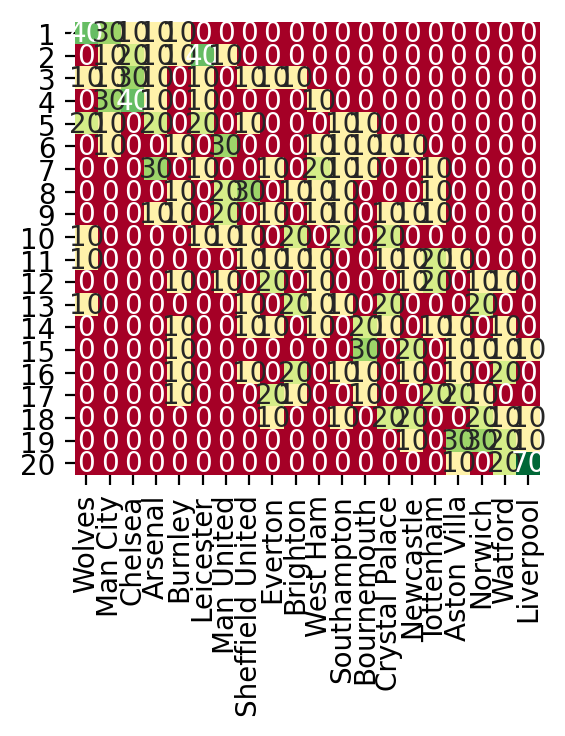

In [ ]:
i = 2
big_list[i].plot_position_crosstab_homeaway()
big_list[i].crosstab

In [ ]:
sim1.set_custom_mu('Liverpool','away','score',3)
#self,team,home_or_away,SorC,value

Liverpool's ExpectedScored value for home games is now 3, previously it was 2.736842105263158


In [ ]:
sim1.resimulate_seasons_homeaway('Liverpool')

In [ ]:
sim1.calc_freq_homeaway()
sim1.plot_hist()

In [ ]:
sim333.expected_values_away.at[16,'ExpectedConceded']=0.61

In [ ]:
sim333 = Simulation(df1920,5000)

sim333.simulate_seasons_homeaway()

sim333.calc_freq_homeaway()
sim333.plot_position_crosstab_homeaway()

In [ ]:
sim111 = Simulation(df1718,1000)
sim111.expected_values_away
sim111.set_custom_mu(team='Liverpool',category='away',SorC='C',value=0.61)


Liverpool's ExpectedConceded value for home games is now 0.61, previously it was 0.8421052631578947


In [ ]:
sim111.simulate_seasons_homeaway()

sim111.calc_freq_homeaway()
sim111.plot_position_crosstab_homeaway()

In [ ]:
sim333.simulate_seasons_homeaway()

sim333.calc_freq_homeaway()
sim333.plot_position_crosstab_homeaway()